# Projet : Implémenter un modèle de scoring (Partie 1)


**Autor** : Louis BIRENHOLZ   
**Date** : 04/05/2020  
**Durée totale** : 110 heures  
**Vidéo de mon projet** : https://www.youtube.com/watch?v=RLGKGFu-9aE&feature=emb_title

Pour ce projet, nous nous plaçons en tant que **Data Scientist** au sein d'une société financière  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. 

Notre entreprise souhaite développer un **modèle de scoring de la probabilité de défaut de paiement du client**. Aussi, nous voulons créer un **dashboard interactif** pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit.

## Partie 1 : Preprocessing & Data Analysis

Ce Notebook réalise un preprocessing et une exploration des données.
On accorde une importance particulière à la phase de cleaning des données du fait du **déséquilibre des classes** sur les targets.

#### Le preprocessing s'articule comme suit:
- Cleaning et Undersampling de la classe majoritaire
- Séléction de features
- Features Engineering (OHE)
- Imputation des valeurs manquantes
- Standardisation

## Librairies

In [12]:
# Classic lib
import numpy as np
import pandas as pd 

# Data viz Lib.
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Feature Engineering
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA

# File system management.
import os

# Import custom functions.
from utils import *

# Settings

In [13]:
# Format & option.
sns.set(rc={'figure.figsize':(16,9)})
pd.options.display.max_columns = 150

# Style use.
sns.set_style('darkgrid')
sns.set_context("notebook", 
                font_scale=1.5, 
                rc={"lines.linewidth": 2.5})
plt.style.use('ggplot')

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Import Data 

Les données sont composées de **9 fichiers**, un dataset principal d'entrainement (avec les targets), un de test, 7 autres apportant des informations supplémentaires sur les clients.

In [14]:
# Liste des fichiers.
print(os.listdir(r"/Users/louisbirenholz/Documents/Project/Python Project/Projet-Scoring-CustomMetric/Data"))

['application_test.csv', '.DS_Store', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


#### Architecture des différentes bases & jointures.

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [15]:
# Importation du dataset. 
df_app_train = pd.read_csv('/Users/louisbirenholz/Documents/Project/Python Project/Projet-Scoring-CustomMetric/Data/application_train.csv')
df_app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Les features:

- Chaque pret est spécifié par son **SK_ID_CURR**
- Chaque pret à sa **TARGET** (0 : `ok` et 1 : `défaillance de paiement`)
- **FLAG_OWN_CAR** : possède sa voiture ou non 
- **AMT_INCOME_TOTAL** : salaire annuel total
- **AMT_CREDIT** : montant total du crédit
- **DAYS_EMPLOYED** : nbr de jours travaillés
- **EXT_SOURCE_1/2/3** : sources extérieures (score entre 0 et 1)

# Check Columns Types

On regarde le type des features, `int`, `float` ou `object` (variables catégoriques)

In [16]:
# Nbr de colonne de chaque types.
df_app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [17]:
# Nombre de classe unique sur les variables qualitatives.
df_app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [18]:
# NaN sur les variables catégoriques.
df_app_train.select_dtypes('object').isna().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [19]:
# Top 50 features avec des valeurs manquantes.
missing_values = missing_values_table(df_app_train)
missing_values.head(25)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [20]:
show_miss_values(df_app_train)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


# Cleaning

In [21]:
# Copie du dataframe pour réaliser un cleaning dessus.
df_app_train2 = df_app_train.copy(deep=True)

<AxesSubplot: title={'center': 'Nbr de NaN des individus avec comme target 0'}, ylabel='Density'>

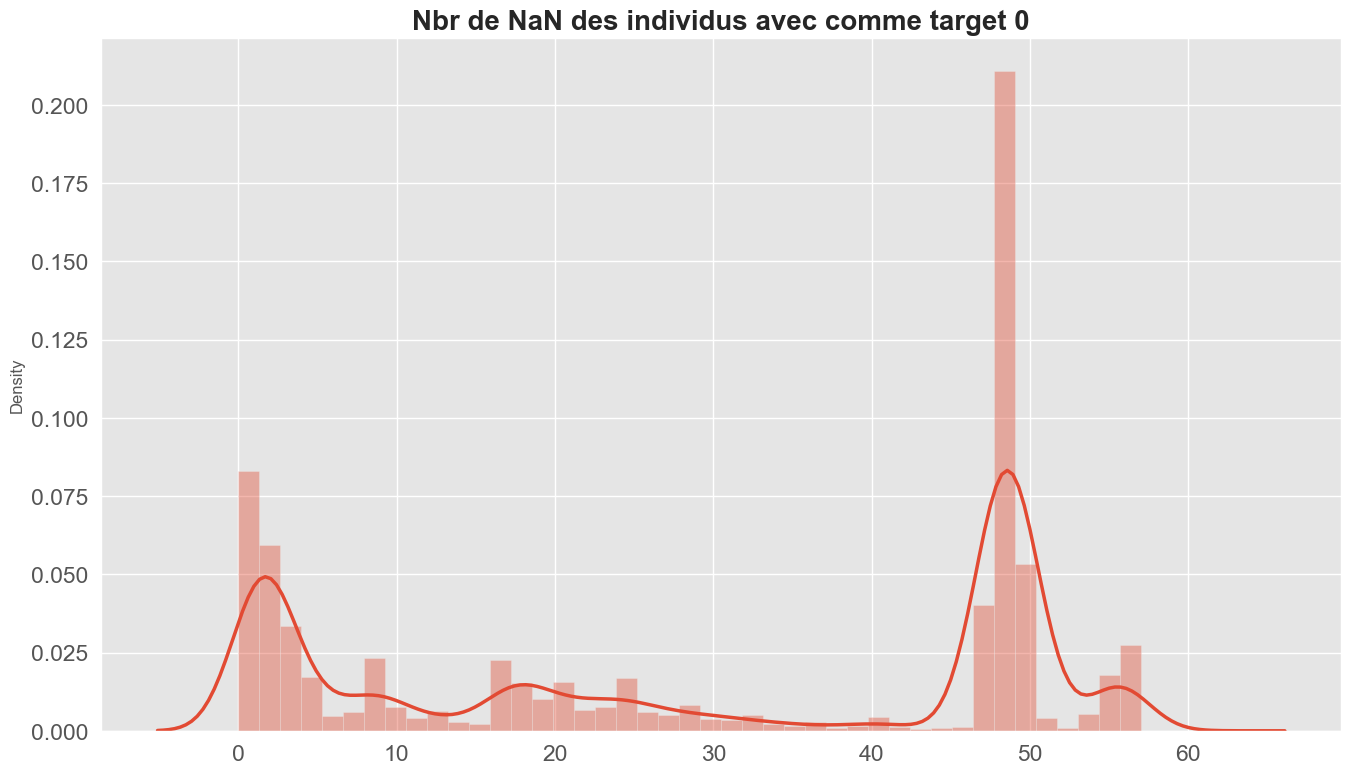

In [22]:
plt.title('Nbr de NaN des individus avec comme target 0', 
          weight='bold', size=20)
sns.distplot(df_app_train2[df_app_train2['TARGET']==0].isna().sum(axis=1))

In [23]:
# Création de la colonne Nbr de NaN.
df_app_train2['Nbr NaN'] = df_app_train2[df_app_train2['TARGET']==0].isna().sum(axis=1)

In [24]:
# Séléction des individus de la classe 0 ayant - de 48 NaN.
df_app_train2_nan_reduce = df_app_train2[df_app_train2['Nbr NaN']<48]

del df_app_train2_nan_reduce['Nbr NaN']
del df_app_train2['Nbr NaN']

In [25]:
df_app_clean_1st = pd.concat([df_app_train2[df_app_train2['TARGET']==1],df_app_train2_nan_reduce]) 

In [26]:
# Replace the anomalous values with nan
df_app_clean_1st['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [27]:
# Features catégoriques comportant le + de NaN.
df_app_clean_1st.select_dtypes('object').isna().sum().sort_values(ascending=False).head(5)

FONDKAPREMONT_MODE     90383
OCCUPATION_TYPE        53317
WALLSMATERIAL_MODE     36440
HOUSETYPE_MODE         34439
EMERGENCYSTATE_MODE    27578
dtype: int64

In [28]:
# Destruction de features comportant trop de NaN.
del df_app_clean_1st['FONDKAPREMONT_MODE']
del df_app_clean_1st['OCCUPATION_TYPE']

## Imputation des features numériques

In [29]:
# Df des features numériques.
df_num = df_app_clean_1st.select_dtypes(['float64','int64']).reset_index(drop = True)

# Df des features catégoriques.
df_categ = df_app_clean_1st.select_dtypes('object').reset_index(drop = True)

In [30]:
# Iterative Imputer.
impute = IterativeImputer(n_nearest_features=15,
                         imputation_order='ascending',
                         random_state=0)

In [31]:
# Imputation via Iterative Imputer.
df_num_imputed = impute.fit_transform(df_num)

df_num_imputed = pd.DataFrame(df_num_imputed, columns=df_num.columns)

In [34]:
df_final = df_num_imputed.copy(deep=True)

## OHE & Fusion de certaines colonnes

In [35]:
# Création des dummies pour chaque features qualitatives.
# Ou Souhaite fusionner des colonnes ou la classe concernée est minoritaire.

dummies = []

for i in df_categ:
    dummies.append(pd.get_dummies(df_categ[i]))
 
for dum,name in zip(dummies,df_categ):
    
    features_to_mix = []
    feature_resume = pd.Series(np.full(df_categ.shape[0],0))
    
    # Calcul du nombre de 0 par colonne.
    nbr_nan = dum.sum().sort_values()
    
    for k,l in zip(nbr_nan, nbr_nan.index):

        if k < 2000:
            features_to_mix.append(l)
        
    for j in features_to_mix:
        
        feature_resume += dum[j].reset_index(drop=True)
        del dum[j]
        dum['{} mix'.format(name)] = feature_resume
    
    
    df_final = pd.concat([df_final, dum], axis=1)    

In [36]:
pd.DataFrame(df_final['SK_ID_CURR']).to_csv('SK_ID_CURR.csv', index=False)

In [37]:
# One hot encoding.
df_categ_ohe = pd.get_dummies(df_categ)

In [38]:
# Fonction permettant de fusionner certaines features crées après OHE.

features = []
features_to_mix = []

for j in df_categ_ohe.columns:

    if 'ORGANIZATION_TYPE' in j:
        features.append(j)

nbr_nan = df_categ_ohe.loc[:,features].sum().sort_values()

for k,l in zip(nbr_nan, nbr_nan.index):

    if k < 1000:
        features_to_mix.append(l)

feature_resume = pd.Series(np.full(df_categ_ohe.shape[0],0))
for i in features_to_mix:
    
    feature_resume += df_categ_ohe[i].reset_index(drop=True)
    del df_categ_ohe[i]
    
df_categ_ohe['ORGANIZATION_TYPE_RESUME'] = feature_resume

In [39]:
# Concaténation après preprocessing.
df_final = pd.concat([df_num_imputed, df_categ_ohe], axis=1)

### Standardisation

In [40]:
# Normalisation entre 0 et 1.
scaler = MinMaxScaler(feature_range=(0, 1))

# Scaling.
scaler.fit(df_final.iloc[:,2:])
df_final.iloc[:,2:] = scaler.transform(df_final.iloc[:,2:])
del df_final['SK_ID_CURR']

### PCA

In [41]:
# ACP avant régression logistique.
pca = PCA(n_components=df_final.iloc[:,np.arange(df_final.shape[1])[1:]].shape[1])
df_final_pca = pd.DataFrame(pca.fit_transform(df_final.iloc[:,np.arange(df_final.shape[1])[1:]]))

In [42]:
# Combien doit-on garder de composantes principales pour expliquer 95% de la variance du dataset ?

for c,i in enumerate(pca.explained_variance_ratio_.cumsum()):
    if(i>0.95):
        print('Il faut {} composantes pour expliquer 95% de la variance du dataset'.format(c))
        break

Il faut 62 composantes pour expliquer 95% de la variance du dataset


In [43]:
df_export = pd.concat([df_final['TARGET'], df_final_pca.iloc[:,np.arange(62)]], axis=1)

In [44]:
# Export.
df_final.to_csv("df_train_imputed.csv", index=False)

# Analyse exploratoire des données

## Check du déséquilibre des targets.

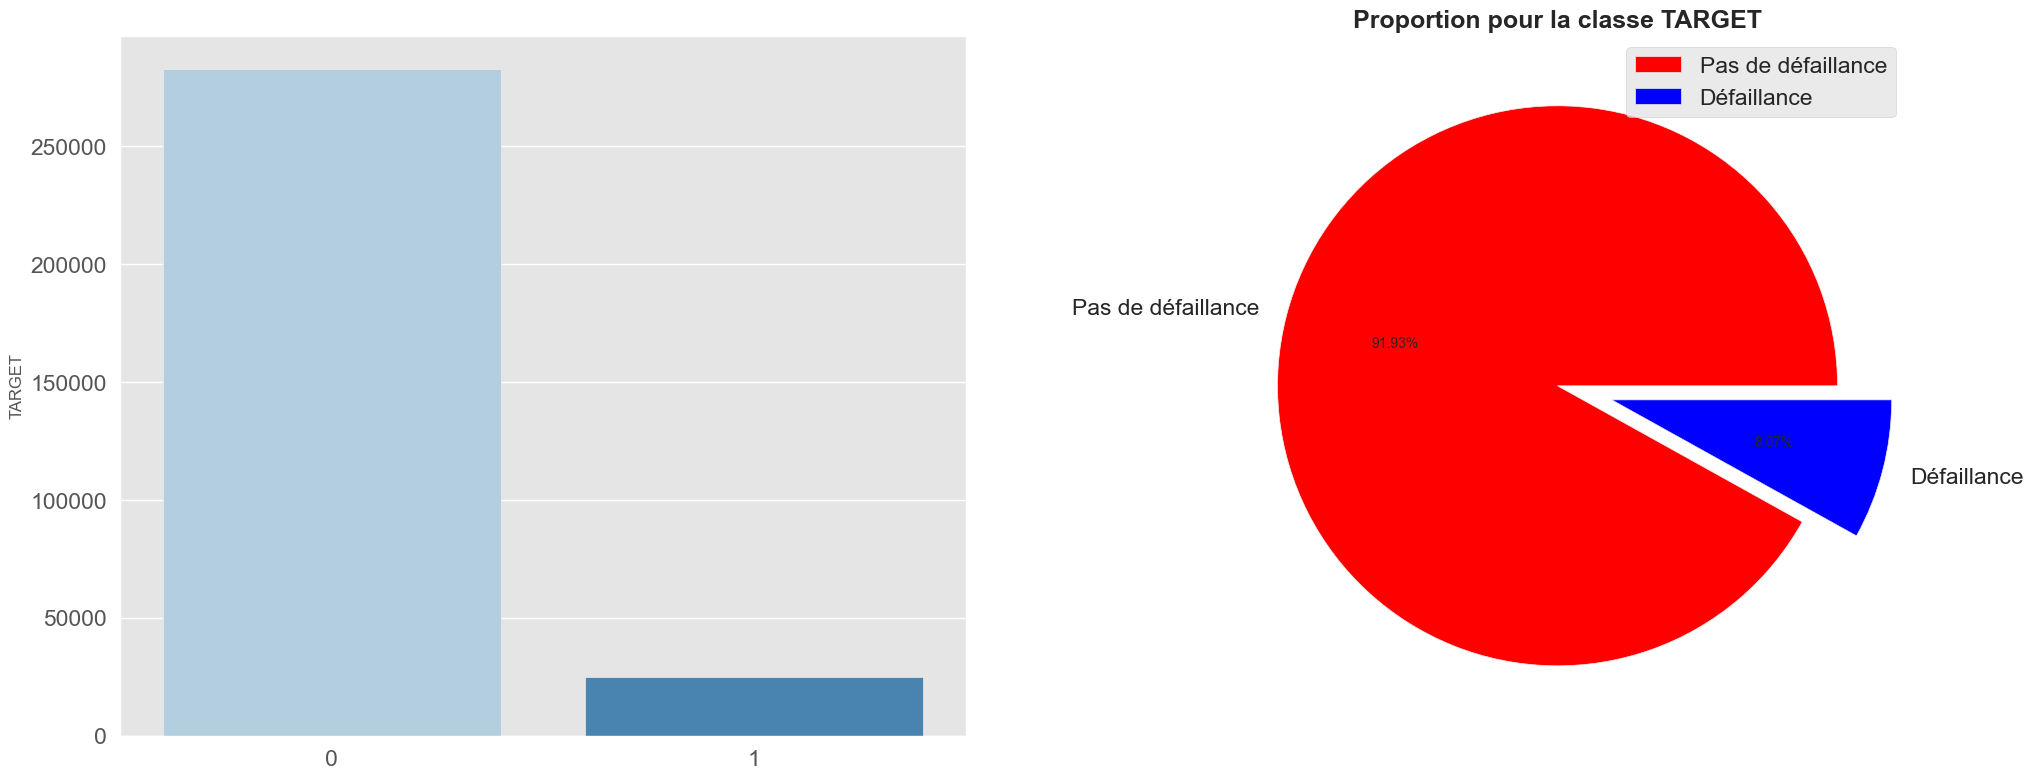

In [45]:
plt.figure(figsize = (24, 20))

plt.subplot(2, 2, 1)
sns.barplot(x=df_app_train['TARGET'].value_counts().index, 
            y=df_app_train['TARGET'].value_counts(),
            palette='Blues')

plt.subplot(2, 2, 2)
plt.title('Proportion pour la classe TARGET', size=18, weight='bold')
plt.pie(df_app_train['TARGET'].value_counts(), 
        labels=['Pas de défaillance', 'Défaillance'],
        colors = ['red', 'blue'], 
        explode = [0, 0.2],
        autopct = lambda x: str(round(x, 2)) + '%')
plt.legend()

On remarque que **les classes sont déséquilibrées**, il y a beaucoup plus d'individus de la classe 0 que de la classe 1.

**Check** du `CODE_GENDER` des demandeurs de crédit.

<AxesSubplot: ylabel='CODE_GENDER'>

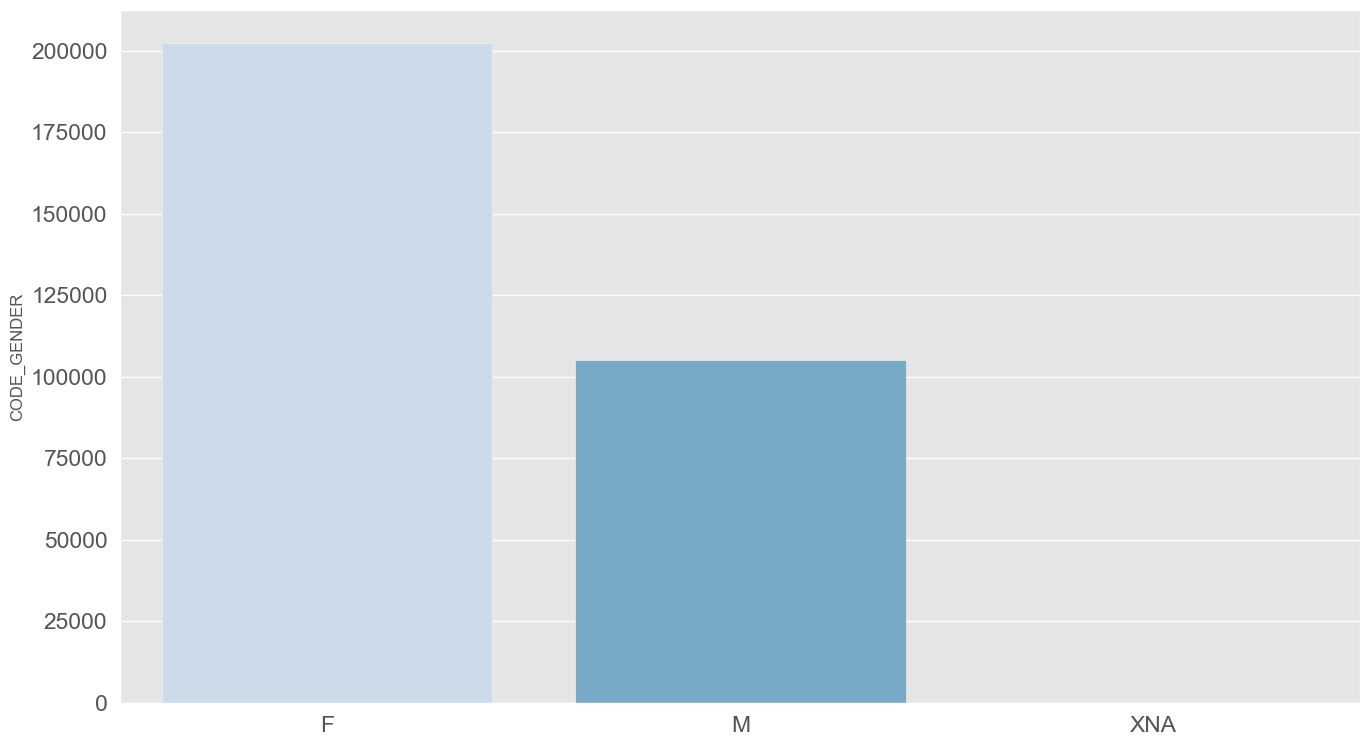

In [46]:
sns.barplot(x=df_app_train['CODE_GENDER'].value_counts().index, 
            y=df_app_train['CODE_GENDER'].value_counts(), palette='Blues')

# Encoding des variables qualitatives

Pour les variables ayant 2 classes possibles ont utilise un **Label Encoding**. Pour les autres un **OHE**.

### Label Encoding and One-Hot Encoding


In [47]:
# Création d'un objet LabelEncoder.
label_encoder = LabelEncoder()
le_count = 0

# Boucle sur les features catégoriques.
for col in df_app_train:
    if df_app_train[col].dtype == 'object':
        
        # Si - de 2 classes.
        if len(list(df_app_train[col].unique())) <= 2:
            
            
            # Train on the training data
            label_encoder.fit(df_app_train[col])
            
            # Encoding des variables.
            df_app_train[col] = label_encoder.transform(df_app_train[col])
            
            # Combien de features encodées ?
            le_count += 1
            
print('%d colonnes ont été encodé.' % le_count)

3 colonnes ont été encodé.


In [48]:
# OHE des autres variables catégoriques.
df_app_train = pd.get_dummies(df_app_train)

print('Training Features shape: ', df_app_train.shape)

Training Features shape:  (307511, 243)


## Retour sur l'analyse exploratoire

### Détection des outliers et anomalies dans le dataset.


In [49]:
(df_app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [50]:
# Feature à inspecter au niveau de potentiels outliers.
features_to_check = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY',
                     'AMT_GOODS_PRICE','DAYS_EMPLOYED','DAYS_REGISTRATION']

In [51]:
df_app_train[features_to_check].describe().round()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_REGISTRATION
count,307511.0,307511.0,307499.0,307233.0,307511.0,307511.0
mean,168798.0,599026.0,27109.0,538396.0,63815.0,-4986.0
std,237123.0,402491.0,14494.0,369446.0,141276.0,3523.0
min,25650.0,45000.0,1616.0,40500.0,-17912.0,-24672.0
25%,112500.0,270000.0,16524.0,238500.0,-2760.0,-7480.0
50%,147150.0,513531.0,24903.0,450000.0,-1213.0,-4504.0
75%,202500.0,808650.0,34596.0,679500.0,-289.0,-2010.0
max,117000000.0,4050000.0,258026.0,4050000.0,365243.0,0.0


<AxesSubplot: title={'center': 'Nombre de jour de travail'}, xlabel='DAYS_EMPLOYED'>

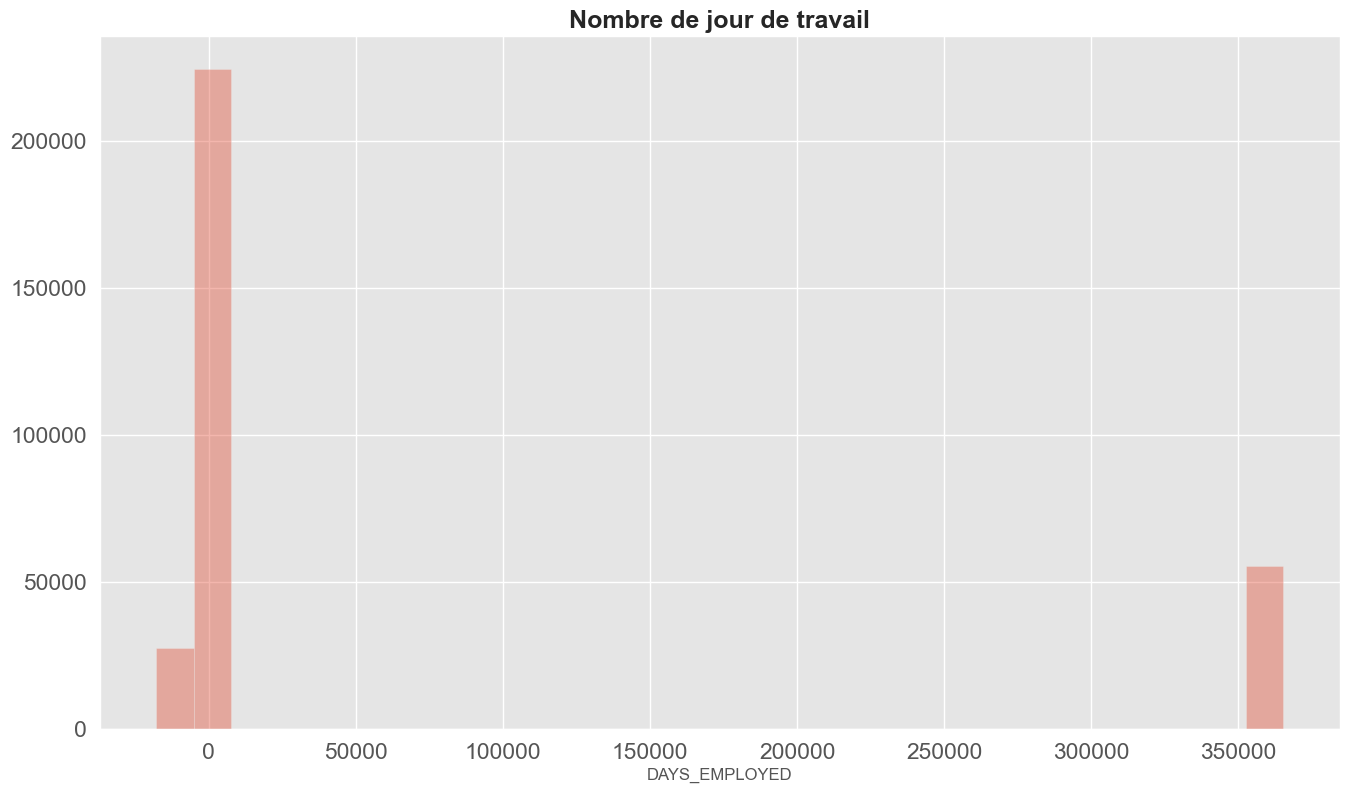

In [52]:
plt.figure(figsize = (16, 9))

plt.title('Nombre de jour de travail', weight='bold', size=18)
sns.distplot(df_app_train['DAYS_EMPLOYED'], kde=False, bins=30)

In [53]:
# Dataframe ayant une anomalie sur la feature DAYS_EMPLOYED.
df_anom = df_app_train[df_app_train['DAYS_EMPLOYED'] == 365243]

# Dataframe n'ayant pas cette anomalie.
df_non_anom = df_app_train[df_app_train['DAYS_EMPLOYED'] != 365243]


print("Quand il n'y a pas cette anomalie, on a %0.2f%% de défaut de paiement" % (100 * df_non_anom['TARGET'].mean()))
print('Quand il y a cette anomalie, on a %0.2f%% de défaut de paiement' % (100 * df_anom['TARGET'].mean()))
print('On voit cette anomalie sur %d clients ' % len(df_anom))

Quand il n'y a pas cette anomalie, on a 8.66% de défaut de paiement
Quand il y a cette anomalie, on a 5.40% de défaut de paiement
On voit cette anomalie sur 55374 clients 


Text(0.5, 0, 'Days Employment')

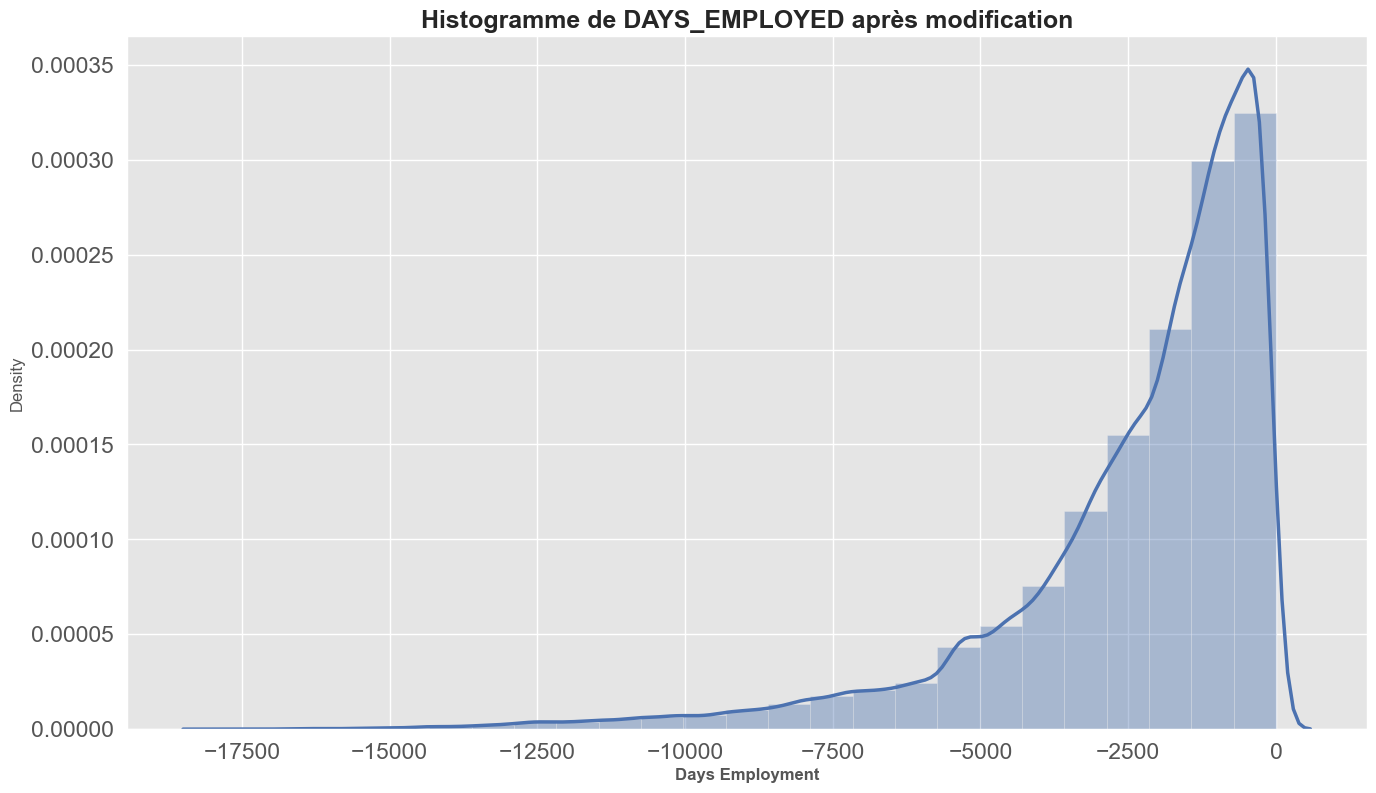

In [54]:
# Create an anomalous flag column
df_app_train['DAYS_EMPLOYED_ANOM'] = df_app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

sns.distplot(df_app_train['DAYS_EMPLOYED'], color='b', bins=25)
plt.title('Histogramme de DAYS_EMPLOYED après modification',
          weight='bold', size=18)
plt.xlabel('Days Employment', weight="bold")

In [55]:
# Même modification dans le testing set.
df_app_test['DAYS_EMPLOYED_ANOM'] = df_app_test["DAYS_EMPLOYED"] == 365243
df_app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (df_app_test["DAYS_EMPLOYED_ANOM"].sum(), 
                                                                        len(df_app_test)))

NameError: name 'df_app_test' is not defined

## Check des corrélations

On regarde dans cette partie les variables corrélée à `TARGET`

In [56]:
# On cherche les variables les plus corrélées à TARGET.
# df.corr(), nous donne l'ensemble des coefficients de pearon entre la variable renseignée et les autres.
correlations = df_app_train.corr()['TARGET'].sort_values()

# Display correlations.
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### Effet de l'âge sur les défauts de paiement

In [85]:
# Find the correlation of the positive days since birth and target
df_app_train['DAYS_BIRTH'] = abs(df_app_train['DAYS_BIRTH'])
df_app_train['DAYS_BIRTH'].corr(df_app_train['TARGET'])

-0.07823930830982712

On trouve **une corrélation négative**, plus le client est vieux moins la probabilité de défaut de paiement est haute.

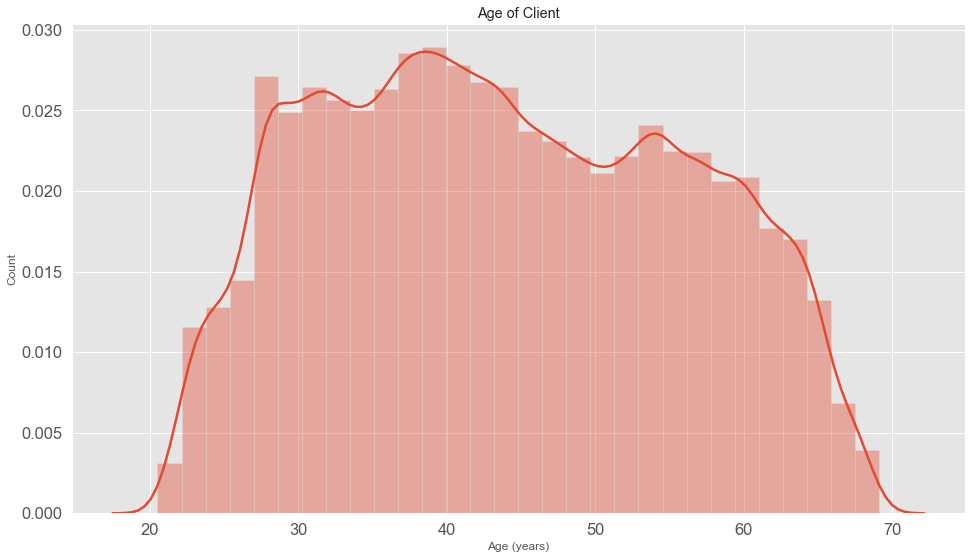

In [41]:
# Distribution des âges. (en année)
sns.distplot(df_app_train['DAYS_BIRTH'] / -365, bins=30)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

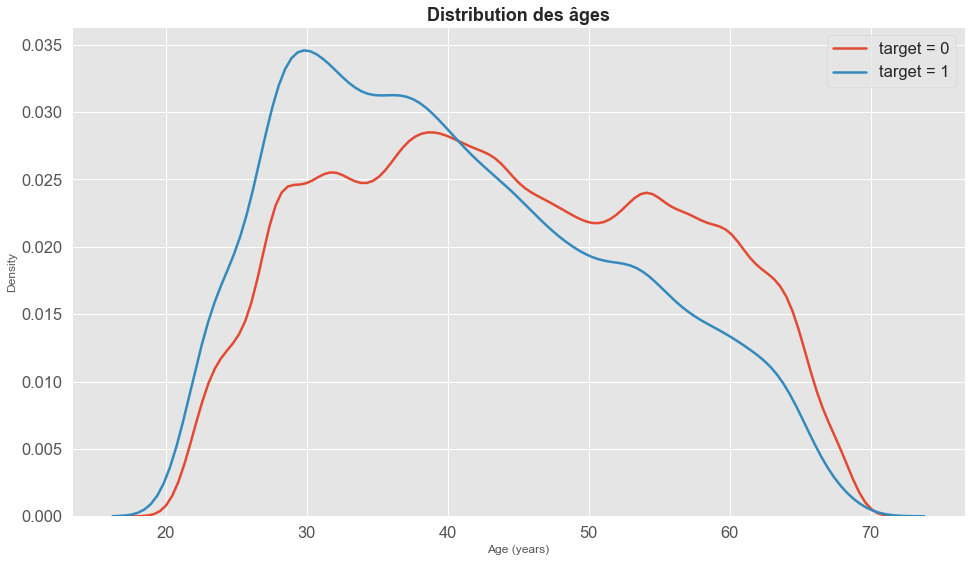

In [45]:
plt.figure(figsize = (16, 9))

# KDE plot pour les crédits payés à temps.
sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target = 0')

# KDE plot pour les défauts de paiement.
sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target = 1')

# Légende.
plt.xlabel('Age (years)'); plt.ylabel('Density')
plt.title('Distribution des âges', weight='bold', size=18);

In [48]:
age_data = df_app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

# Découpage par tranche d'âge.
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

# On regroupe par tranche crée
age_groups = age_data.groupby('YEARS_BINNED').mean()

Text(0.5, 1.0, "Défaut de paiement par tranche d'âge")

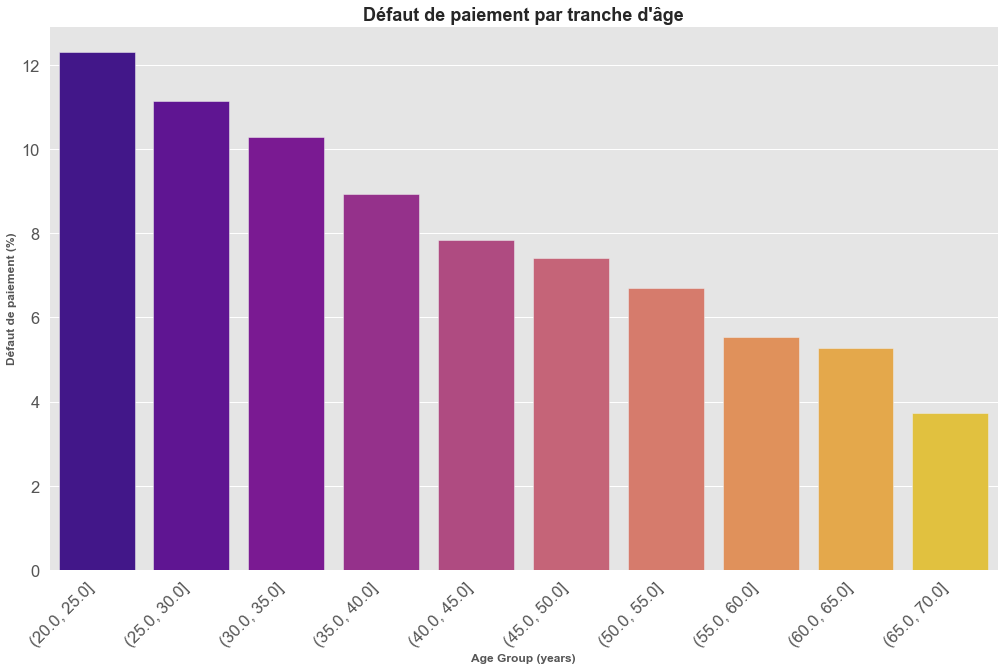

In [59]:
plt.figure(figsize=(17, 10))

# Graph the age bins and the average of the target as a bar plot
sns.barplot(age_groups.index, 100 * age_groups['TARGET'], palette='plasma')

# Plot labeling
plt.xticks(rotation = 45, ha="right") 
plt.xlabel('Age Group (years)', weight='bold') 
plt.ylabel('Défaut de paiement (%)', weight='bold')
plt.title("Défaut de paiement par tranche d'âge",
          weight='bold', size=18)

## Sources extérieures

 `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3` ont une **"forte"** corrélation négative avec **TARGET**.
According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [60]:
# Check des corrélations.
ext_data = df_app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


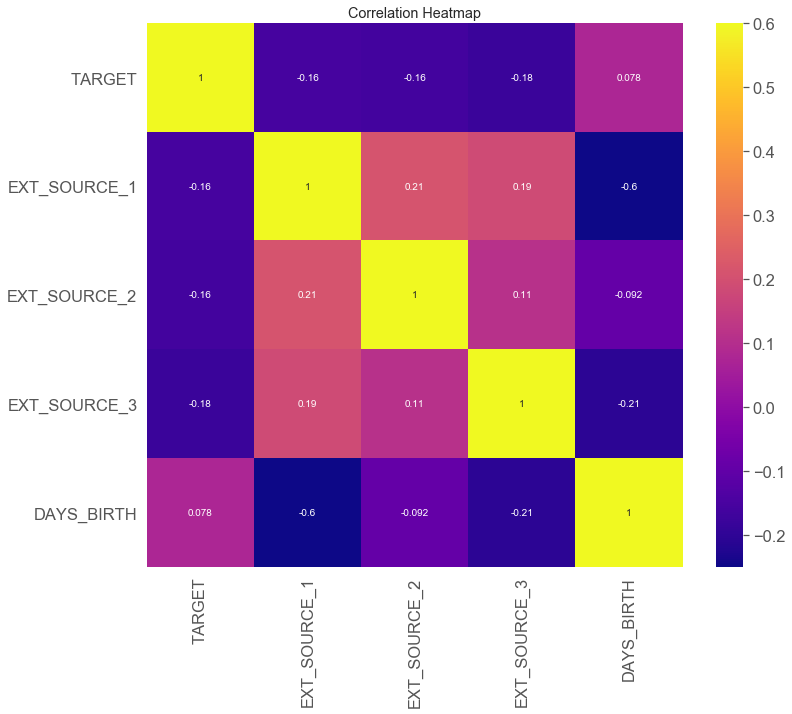

In [64]:
plt.figure(figsize = (12, 10))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap='plasma', vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

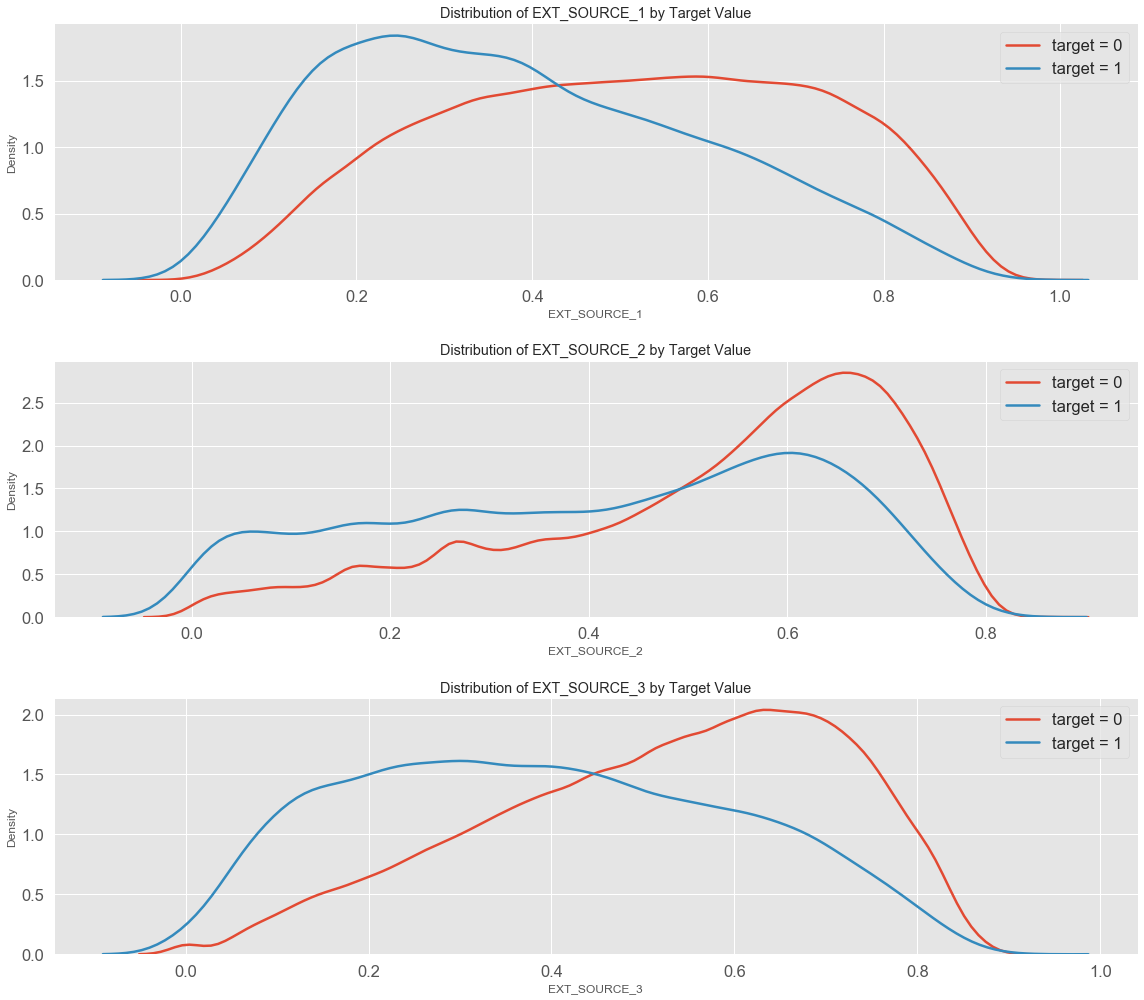

In [65]:
plt.figure(figsize = (16, 14))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 0, source], label = 'target = 0')
    # plot loans that were not repaid
    sns.kdeplot(df_app_train.loc[df_app_train['TARGET'] == 1, source], label = 'target = 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# Pairs Plot

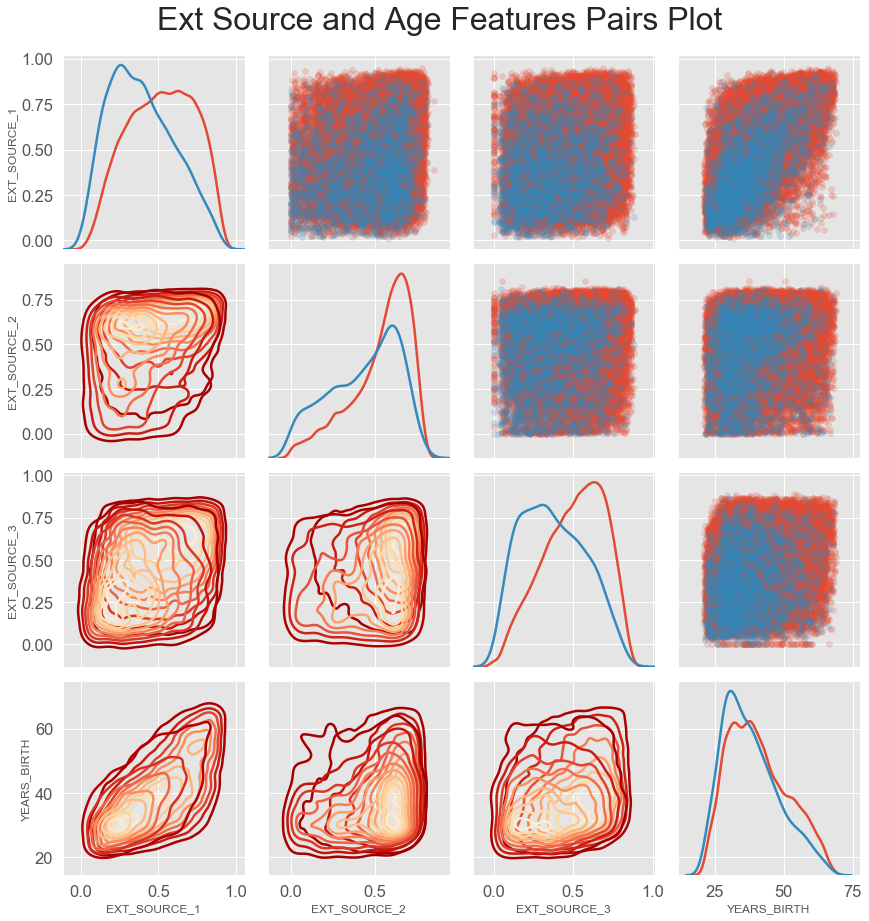

In [66]:
# Copy the data for plotting
plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop des NaN et séléction des 100 000 premières lignes.
plot_data = plot_data.dropna().loc[:100000, :]

# Fonction pour calculer la corrélation entre 2 colonnes.
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Création des scatter plots dans la partie haute.
grid.map_upper(plt.scatter, alpha = 0.2)

# Distribution sur la diagonale.
grid.map_diag(sns.kdeplot)

# Graph de densité sur la partie basse.
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

# Feature Engineering


Cette partie consiste en la construction et séléction de features.

**On utilisera les méthodes suivantes :**

* Polynomial features
* Domain knowledge features


## Polynomial Features

Dans le code suivant nous utiliserons les features `EXT_SOURCE` pour créer les features polynomiales.
Cette création de nouvelles variables permet de **capturer l'intéraction** entre ces features (en créant des combinaisons entre elles).


In [141]:
# Make a new dataframe for polynomial features.
df_poly_features = df_app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
df_poly_features_test = df_app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

In [142]:
# Imputation des valeures manquantes.
imputer = IterativeImputer(max_iter=10, random_state=0)

df_poly_features = pd.DataFrame(imputer.fit_transform(df_poly_features))
df_poly_features.columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']

df_poly_features_test = pd.DataFrame(imputer.fit_transform(df_poly_features_test))
df_poly_features_test.columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']

In [143]:
# Create the polynomial object with specified degree.
poly_transformer = PolynomialFeatures(degree = 3)

df_poly_target = df_poly_features['TARGET']
df_poly_features = df_poly_features.drop(columns=['TARGET'])

# Train the polynomial features.
poly_transformer.fit(df_poly_features)

# Transformation des features.
df_poly_features = poly_transformer.transform(df_poly_features)
df_poly_features_test = poly_transformer.transform(df_poly_features_test)
print('Polynomial Features shape: ', df_poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [144]:
# Check des variables crées.
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [151]:
# Create a dataframe of the features 
df_poly_features = pd.DataFrame(df_poly_features, 
                                columns=poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
df_poly_features['TARGET'] = df_poly_target

# Find the correlations with the target
df_poly_corrs =df_poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print('Most Positive Correlations avec TARGET:\n', df_poly_corrs.head(10))
print('\nMost Negative Correlations avec TARGET:\n',df_poly_corrs.tail(5))

Most Positive Correlations avec TARGET:
 EXT_SOURCE_1 EXT_SOURCE_3                -0.226620
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.217945
EXT_SOURCE_2 EXT_SOURCE_3                -0.213829
EXT_SOURCE_1^2 EXT_SOURCE_3              -0.206079
EXT_SOURCE_1 EXT_SOURCE_2                -0.204778
EXT_SOURCE_1                             -0.202107
EXT_SOURCE_3                             -0.201293
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.200446
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.194841
EXT_SOURCE_1^2 EXT_SOURCE_2              -0.192181
Name: TARGET, dtype: float64

Most Negative Correlations avec TARGET:
 EXT_SOURCE_3 DAYS_BIRTH                 0.176439
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH    0.183075
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.194612
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


On remarque que des **nouvelles variables** crées ont de "meilleures" corrélations. 
Ces variables vont être intéressantes pour renforcer nos sets.

In [152]:
# Put test features into dataframe
df_poly_features_test = pd.DataFrame(df_poly_features_test, 
                                     columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
df_poly_features['SK_ID_CURR'] = df_app_train['SK_ID_CURR']
df_app_train_poly = df_app_train.merge(df_poly_features, on='SK_ID_CURR', how='left')

# Merge polnomial features into testing dataframe
df_poly_features_test['SK_ID_CURR'] = df_app_test['SK_ID_CURR']
df_app_test_poly = df_app_test.merge(df_poly_features_test, on='SK_ID_CURR', how='left')

# Align the dataframes
df_app_train_poly, df_app_test_poly = df_app_train_poly.align(df_app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', df_app_train_poly.shape)
print('Testing data with polynomial features shape:  ', df_app_test_poly.shape)

Training data with polynomial features shape:  (307511, 274)
Testing data with polynomial features shape:   (48744, 274)


# Fin du preprocessing

In [17]:
from sklearn.impute import SimpleImputer

# Imputation des valeures manquantes.

# Feature names
features_names = list(df_app_train.columns)

# Copy of the training and testing set.
df_train = df_app_train.iloc[:,1:].copy()


# Normalisation entre 0 et 1.
scaler = MinMaxScaler(feature_range=(0, 1))

# Scaling.
scaler.fit(df_train)
df_train = scaler.transform(df_train)

print('Training data shape: ', df_train.shape)
print('Testing data shape: ', df_test.shape)

Training data shape:  (307511, 243)
Testing data shape:  (48744, 238)


In [18]:
df_app_train.iloc[:,1:] = df_train

In [21]:
# Exporation des données.
df_app_train.to_csv('df_train_not_imputed.csv', index=False)